# Lecture 33 - Classification and a Binary Classifier Zoo

*in which Scott tries to fit about 60% of a machine learning course into 50 minutes*

#### Announcements:
* Lab 8 due tomorrow night
* Lab 9 (last lab!), assigned Friday, will be due Friday of prep week (12/3) to give you flexibility with Thanksgiving and work on your Final Project.

#### Goals:
* Understand the basic formulation for a linear classifier
* Gain some basic intuition for a handful of different classification models
* Know how to train and evaluate these models using sklearn
* Know how binary classifiers can be generalized to multiclass classifiers

In [1]:
# Code for this lecture adapted from the sklearn examples:
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# Modified for DATA 311 by Scott Wehrwein
# License: BSD 3 clause

Import basic packages and data-munging tools:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

Make three synthetic, 2D binary classification data sets:

In [9]:
def scale_split(ds):
    """ Apply standard scaling and split into train/val sets."""
    X, y = ds
    X = StandardScaler().fit_transform(X)
    Xtr, Xva, ytr, yva = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    
    # Create a dense grid so we can show the decision boundary/classifier scores
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    return (Xtr, Xva, ytr, yva, xx, yy)
    
N = 100
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = {
    "Linearly Separable": scale_split(linearly_separable),
    "Moons": scale_split(make_moons(n_samples=N, noise=0.3, random_state=0)),
    "Circles": scale_split(make_circles(n_samples=N, noise=0.2, factor=0.5, random_state=1)),
}


Plot the datasets:

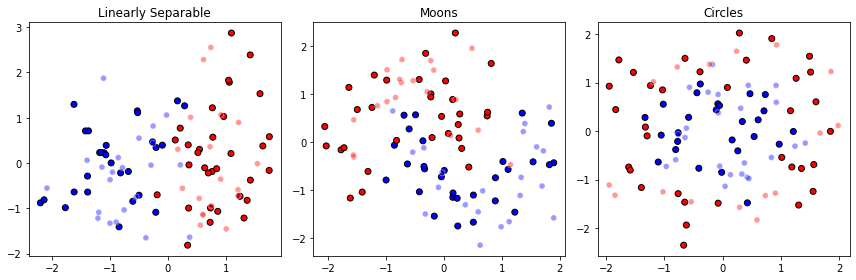

In [10]:
figure = plt.figure(figsize=(12, 4))

for i, ds_name in enumerate(datasets):
    (Xtr, Xva, ytr, yva, xx, yy) = datasets[ds_name]
    
    # just plot the dataset first
    ax = plt.subplot(1, 3, i+1)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax.set_title(ds_name)
    # Plot the training points
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        Xva[:, 0], Xva[:, 1], c=yva, cmap=cm_bright, alpha=0.4, edgecolors="w"
    )

#     ax.set_xticks(())
#     ax.set_yticks(())
    i += 1
plt.tight_layout()


## What exactly are we trying to do here?

See written notes:
* decision boundaries
* score function for every point in feature space

## Linear Regression, But For Classification?

The simplest regression model we could come up with was linear regression, which assumes that $y$ is a linear function of the input vector $\mathbf{x}$.

What's the corresponding model for classification? 
* Still assume a linear model $\hat{y} = \mathbf{x} \cdot \mathbf{w}$.
* However, $\hat{y}$ should not be directly interpreted as a class label (it is continuous, after all).
* Instead, map $\hat{y}$ to $y$ using some function $h$ that encodes our intuition about how classifiers should work.

Multiple possible choices for $h$:
* Sign function: $y = \mathrm{sign}({\hat{y}})$
    * "Which side of the decision boundary is it on?"
* Sigmoid function: $y = \frac{1}{1+e^{-\hat{y}}}$
    * What's the *probability* of it being positive?

Multiple variants of linear classifiers exist with the same modeling assumptions. Their variations derive from on how you *find* the linear weights $\mathbf{w}$.

## But how do we actually find $\mathbf{w}$?

Cheeky answer: Math.

Less cheeky answer: Start with a random $\mathbf{w}$ and **wiggle it** in a direction that makes your model perform better until wiggling it doesn't make it better.

This applies to linear regression, linear classifiers, and the vast majority **all of machine learning models in use today.**

A nice visualization of what this looks like (albeit with a more complicated model) is [here](https://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html). Try replacing the block of `layer_defs` with the following:
```
layer_defs = [];
layer_defs.push({type:'input', out_sx:1, out_sy:1, out_depth:2});
layer_defs.push({type:'softmax', num_classes:2});
```

## How do you do multilabel classification?

Some classifiers handle this naturally by outputting a score or probability for each class.

Other classifiers don't; you can adapt them to multiclass classifiers using a *one-vs-rest* strategy:
* Train one binary classifier that treats one class as positive and the rest as negative.
* Return the label with the highest probability or best score.

## Classifier Zoo

Meet the classifiers:

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [12]:
classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Logistic Regression": LogisticRegression(),
    "Linear SVM": SVC(kernel="linear", C=0.025),
    "RBF SVM": SVC(gamma=2, C=1),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Neural Network": MLPClassifier((20, 100), alpha=1, max_iter=1000),
    "Naive Bayes": GaussianNB(),
}

Some matplotlib drudgery to plot the results of running a classifier on one of the above datasets:

In [16]:
def plot_clf_results(ds_name, Z, accuracy, ax):
    """ Given a trained classifier clf, run it on dataset ds_name and plot
    the results in axes ax."""

    (Xtr, Xva, ytr, yva, xx, yy) = datasets[ds_name]
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.imshow(Z[::-1,:], cmap=cm, alpha=0.8, extent=[xx.min(), xx.max(), yy.min(), yy.max()])

    # Plot the training points
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(Xva[:, 0], Xva[:, 1], c=yva, cmap=cm_bright, edgecolors="w", alpha=0.4)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(ds_name)
    ax.text(xx.max() - 0.3, yy.min() + 0.3,
            ("%.2f" % accuracy).lstrip("0"), size=15, horizontalalignment="right")

This function trains a single classifier from the zoo above on each of the datasets and uses `plot_clf_results` to show the results.

In [14]:
def classify_datasets(clf_name):
    clf = classifiers[clf_name]
    figure = plt.figure(figsize=(12, 5))
    figure.suptitle(clf_name)
    for i, ds_name in enumerate(datasets):
        (Xtr, Xva, ytr, yva, xx, yy) = datasets[ds_name]
        
        ## Train and run the model on the validation set:
        clf.fit(Xtr, ytr)
        accuracy = clf.score(Xva, yva)
        
        # Also generate a decision score for every point in the 2D plot
        # we're making so we can visualize the decision boundary
        if hasattr(clf, "decision_function"):
            # some classifiers give a "decision function" that outputs a score
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            # others output a probability of each class
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        
        ## The Plotting Part:
        ax = plt.subplot(1, 3, i+1)
        plot_clf_results(ds_name, Z, accuracy, ax)

    plt.tight_layout()
    plt.show()

## A whirlwind tour of the zoo

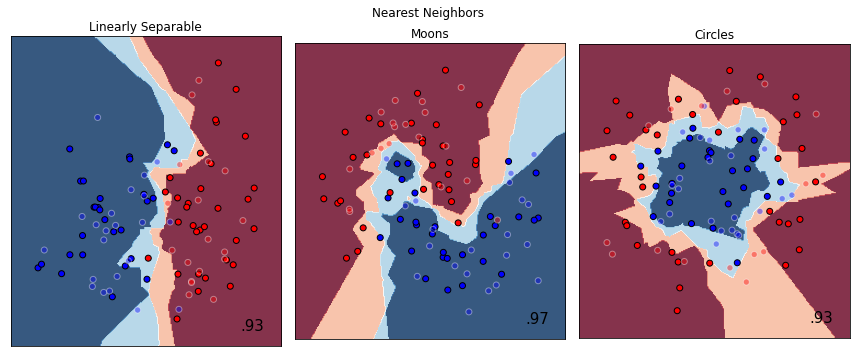

In [18]:
classify_datasets("Nearest Neighbors")

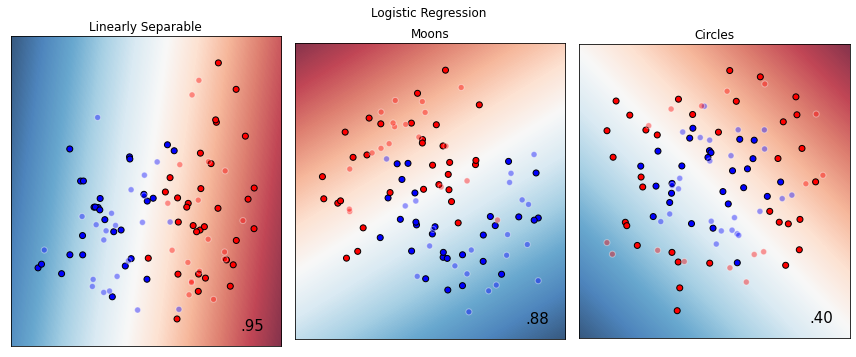

In [19]:
classify_datasets("Logistic Regression")

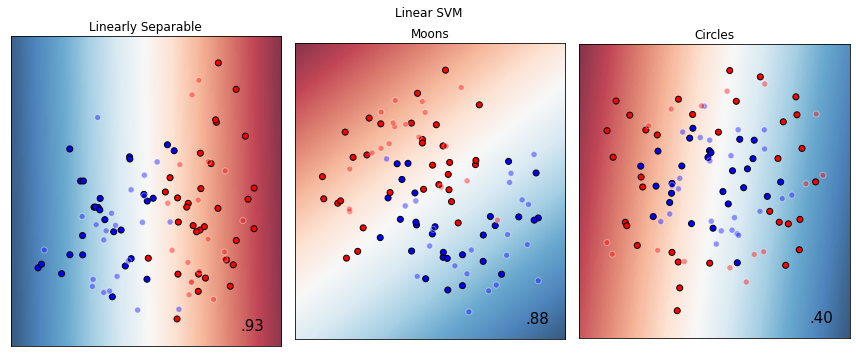

In [20]:
classify_datasets("Linear SVM")

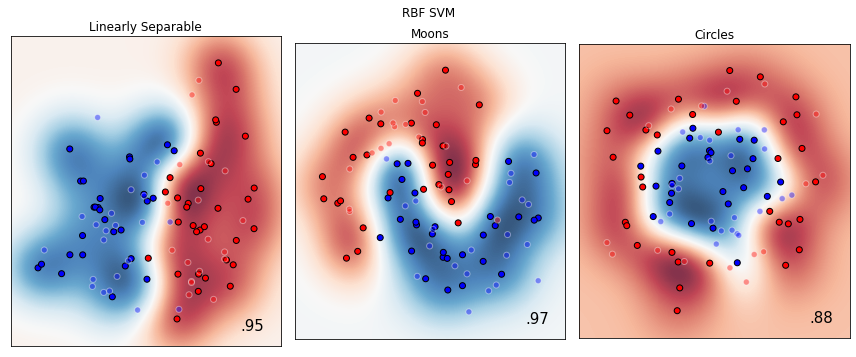

In [21]:
classify_datasets("RBF SVM")

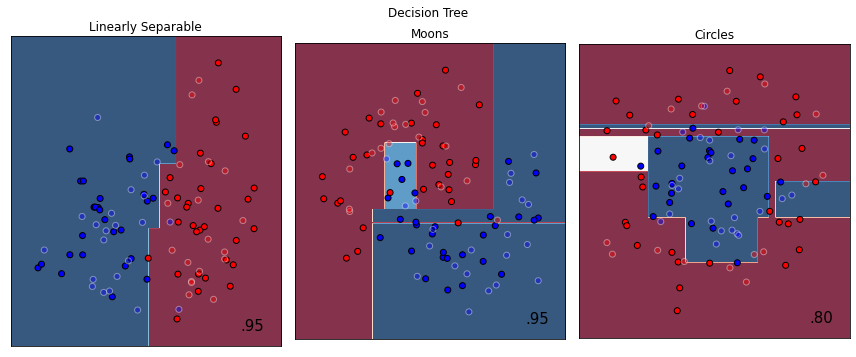

In [22]:
classify_datasets("Decision Tree")

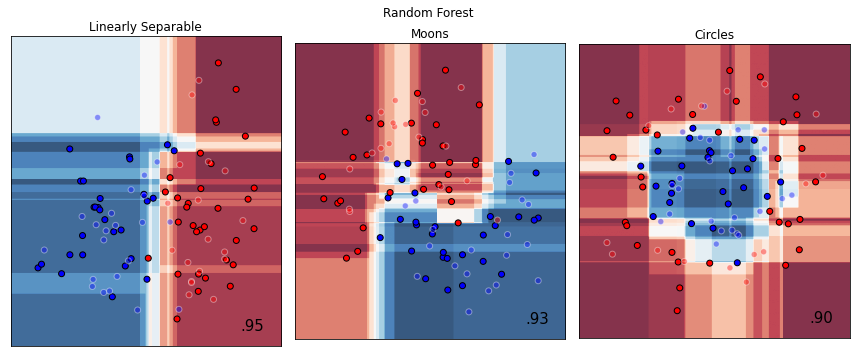

In [24]:
classify_datasets("Random Forest")

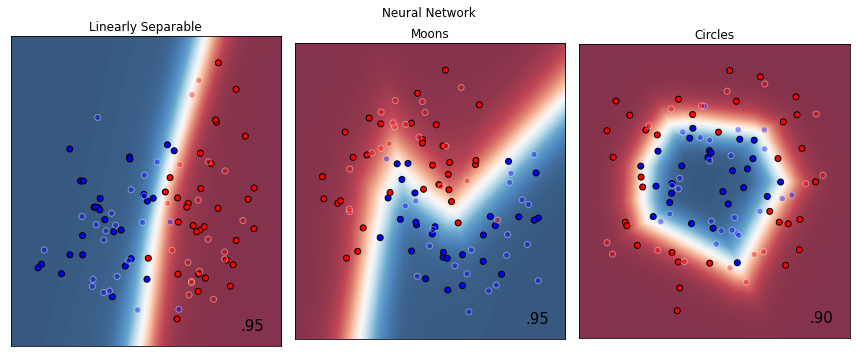

In [25]:
classify_datasets("Neural Network")

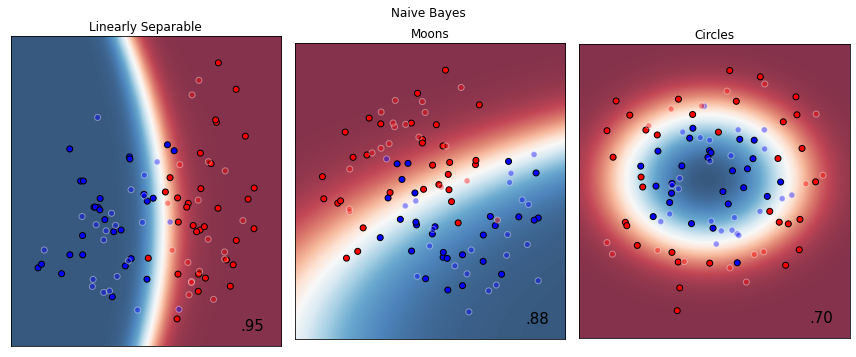

In [26]:
classify_datasets("Naive Bayes")